In [2]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import json

In [6]:
df = pd.read_csv('../tables/TableS3B_VST.csv')
df.head()

,Chromosome,Start,VST_AZ_TXMXSA_CB,gene,Tucson_9,Phoenix_7,Tucson_21,Phoenix_2,Tucson_19,Phoenix_9,...,4545-MICE_Venezuela,3796_Venezuela,Nuevo_Leon_1,730334_Guatemala,Nuevo_Leon_2,San_Antonio_1,GT002_Texas,Coahuila_2,Sonora_1,B5773_Brazil
0,CP075068.1,1,0.103125,NaN,1,1,1,1,1,1,...,1,1,1,1,1,2,1,1,1,1
1,CP075068.1,251,0.103125,NaN,1,1,1,1,1,1,...,1,1,1,1,1,2,1,1,1,1
2,CP075068.1,501,0.103125,NaN,1,1,1,1,1,1,...,1,1,1,1,1,2,1,1,1,1
3,CP075068.1,751,0.103125,NaN,1,1,1,1,1,1,...,1,1,1,1,1,2,1,1,1,1
4,CP075068.1,1001,0.103125,NaN,1,1,1,1,1,1,...,1,1,1,1,1,2,1,1,1,1


In [7]:
#add pop info
pop_dict = json.load(open('../isolate_and_pop_info/pop_dict.json'))
for strain, pops in pop_dict.items():
    pop_dict[strain] = pops
    
drop_strains = [s for s in df.columns[8:] if s not in pop_dict]
df = df.drop(drop_strains, axis=1)

sorted_strain_cols = sorted(pop_dict, key=pop_dict.get)

In [8]:
df = df[df.columns[:6].tolist() + sorted_strain_cols]

In [9]:
df['VST_AZ_TXMXSA_CB'] = df['VST_AZ_TXMXSA_CB'].fillna(0)

In [12]:
gff_path = '../ref/genbank_files/CpSilv.genes_only.gff3'
gff = pd.read_csv(gff_path, sep='\t', header=None)[[0,2,3,4,6,8]]
gff.columns = ['chrom', 'type', 'start', 'stop', 'direction', 'annotation']
gff['name'] = gff['annotation'].str.split(';',expand=True)[0].str.replace('ID=gene-','')

gff.head()

,chrom,type,start,stop,direction,annotation,name
0,CP075068.1,gene,57375,57980,-,ID=gene-D8B26_000001;Name=D8B26_000001;gbkey=G...,D8B26_000001
1,CP075068.1,gene,58131,58768,-,ID=gene-D8B26_000002;Name=D8B26_000002;gbkey=G...,D8B26_000002
2,CP075068.1,gene,58628,59933,-,ID=gene-D8B26_000003;Name=D8B26_000003;gbkey=G...,D8B26_000003
3,CP075068.1,gene,60054,62173,-,ID=gene-D8B26_000004;Name=D8B26_000004;gbkey=G...,D8B26_000004
4,CP075068.1,gene,126638,126720,+,ID=gene-D8B26_000005;Name=D8B26_000005;gbkey=G...,D8B26_000005


In [13]:
repeatmasker_path = '../ref/RepeatMasker/CpSilv_core_only.fasta.out.gff'
repeatmasker = pd.read_csv(repeatmasker_path, sep='\t', header=None, comment='#')[[0,2,3,4,6,8]]
repeatmasker.columns = ['chrom', 'type', 'start', 'stop', 'direction', 'annotation']

nuc_repeats = repeatmasker[(repeatmasker['annotation'].str.contains(r'\([A-Z]+\)')) | (repeatmasker['annotation'].str.contains('-rich'))]
transposons = repeatmasker[~repeatmasker.index.isin(nuc_repeats.index)]

transposons

,chrom,type,start,stop,direction,annotation
1,CP075068.1,similarity,116,292,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-..."
2,CP075068.1,similarity,157,1136,+,"Target ""Motif:RXX-TRIM_Blc207_Cpos_C735-L-B65-..."
3,CP075068.1,similarity,993,1672,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-..."
5,CP075068.1,similarity,1708,9391,-,"Target ""Motif:DTX-incomp-chim_Blc56_Cpos_C735-..."
6,CP075068.1,similarity,8471,16405,-,"Target ""Motif:DTX-incomp-chim_Blc41_Cpos_C735-..."
...,...,...,...,...,...,...
11265,CP075072.1,similarity,1463409,1464429,-,"Target ""Motif:DTX-incomp-chim_Blc73_Superconti..."
11266,CP075072.1,similarity,1463830,1471523,-,"Target ""Motif:DTX-incomp_Blc54_Supercontig_3.5..."
11267,CP075072.1,similarity,1470023,1472092,+,"Target ""Motif:RXX-LARD_Blc184_Cpos_C735-L-B59-..."
11268,CP075072.1,similarity,1472093,1481680,+,"Target ""Motif:DTX-incomp-chim_Blc41_Cpos_C735-..."


In [14]:
chr_lens = {'CP075068.1':8340845,
            'CP075069.1':8079863,
            'CP075070.1':6494557,
            'CP075071.1':3437093,
            'CP075072.1':1489275}

chr_lens_norm = {}
total_length = sum(chr_lens.values())

for chrom, length in chr_lens.items():
    chr_lens_norm[chrom] = length/total_length

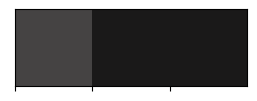

In [15]:
line_cmap = ['#454343', '#1a1919', '#1a1919',]
sns.palplot(line_cmap)
plt.show()

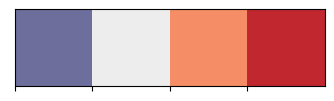

In [16]:
cmap = [ '#6e6e9c', '#ededed', '#f58d67', '#C0272F']
sns.palplot(cmap)
plt.show()

In [17]:
num_to_roman = {1:'I', 2:'II', 3:'III', 4:'IV', 5:'V'}

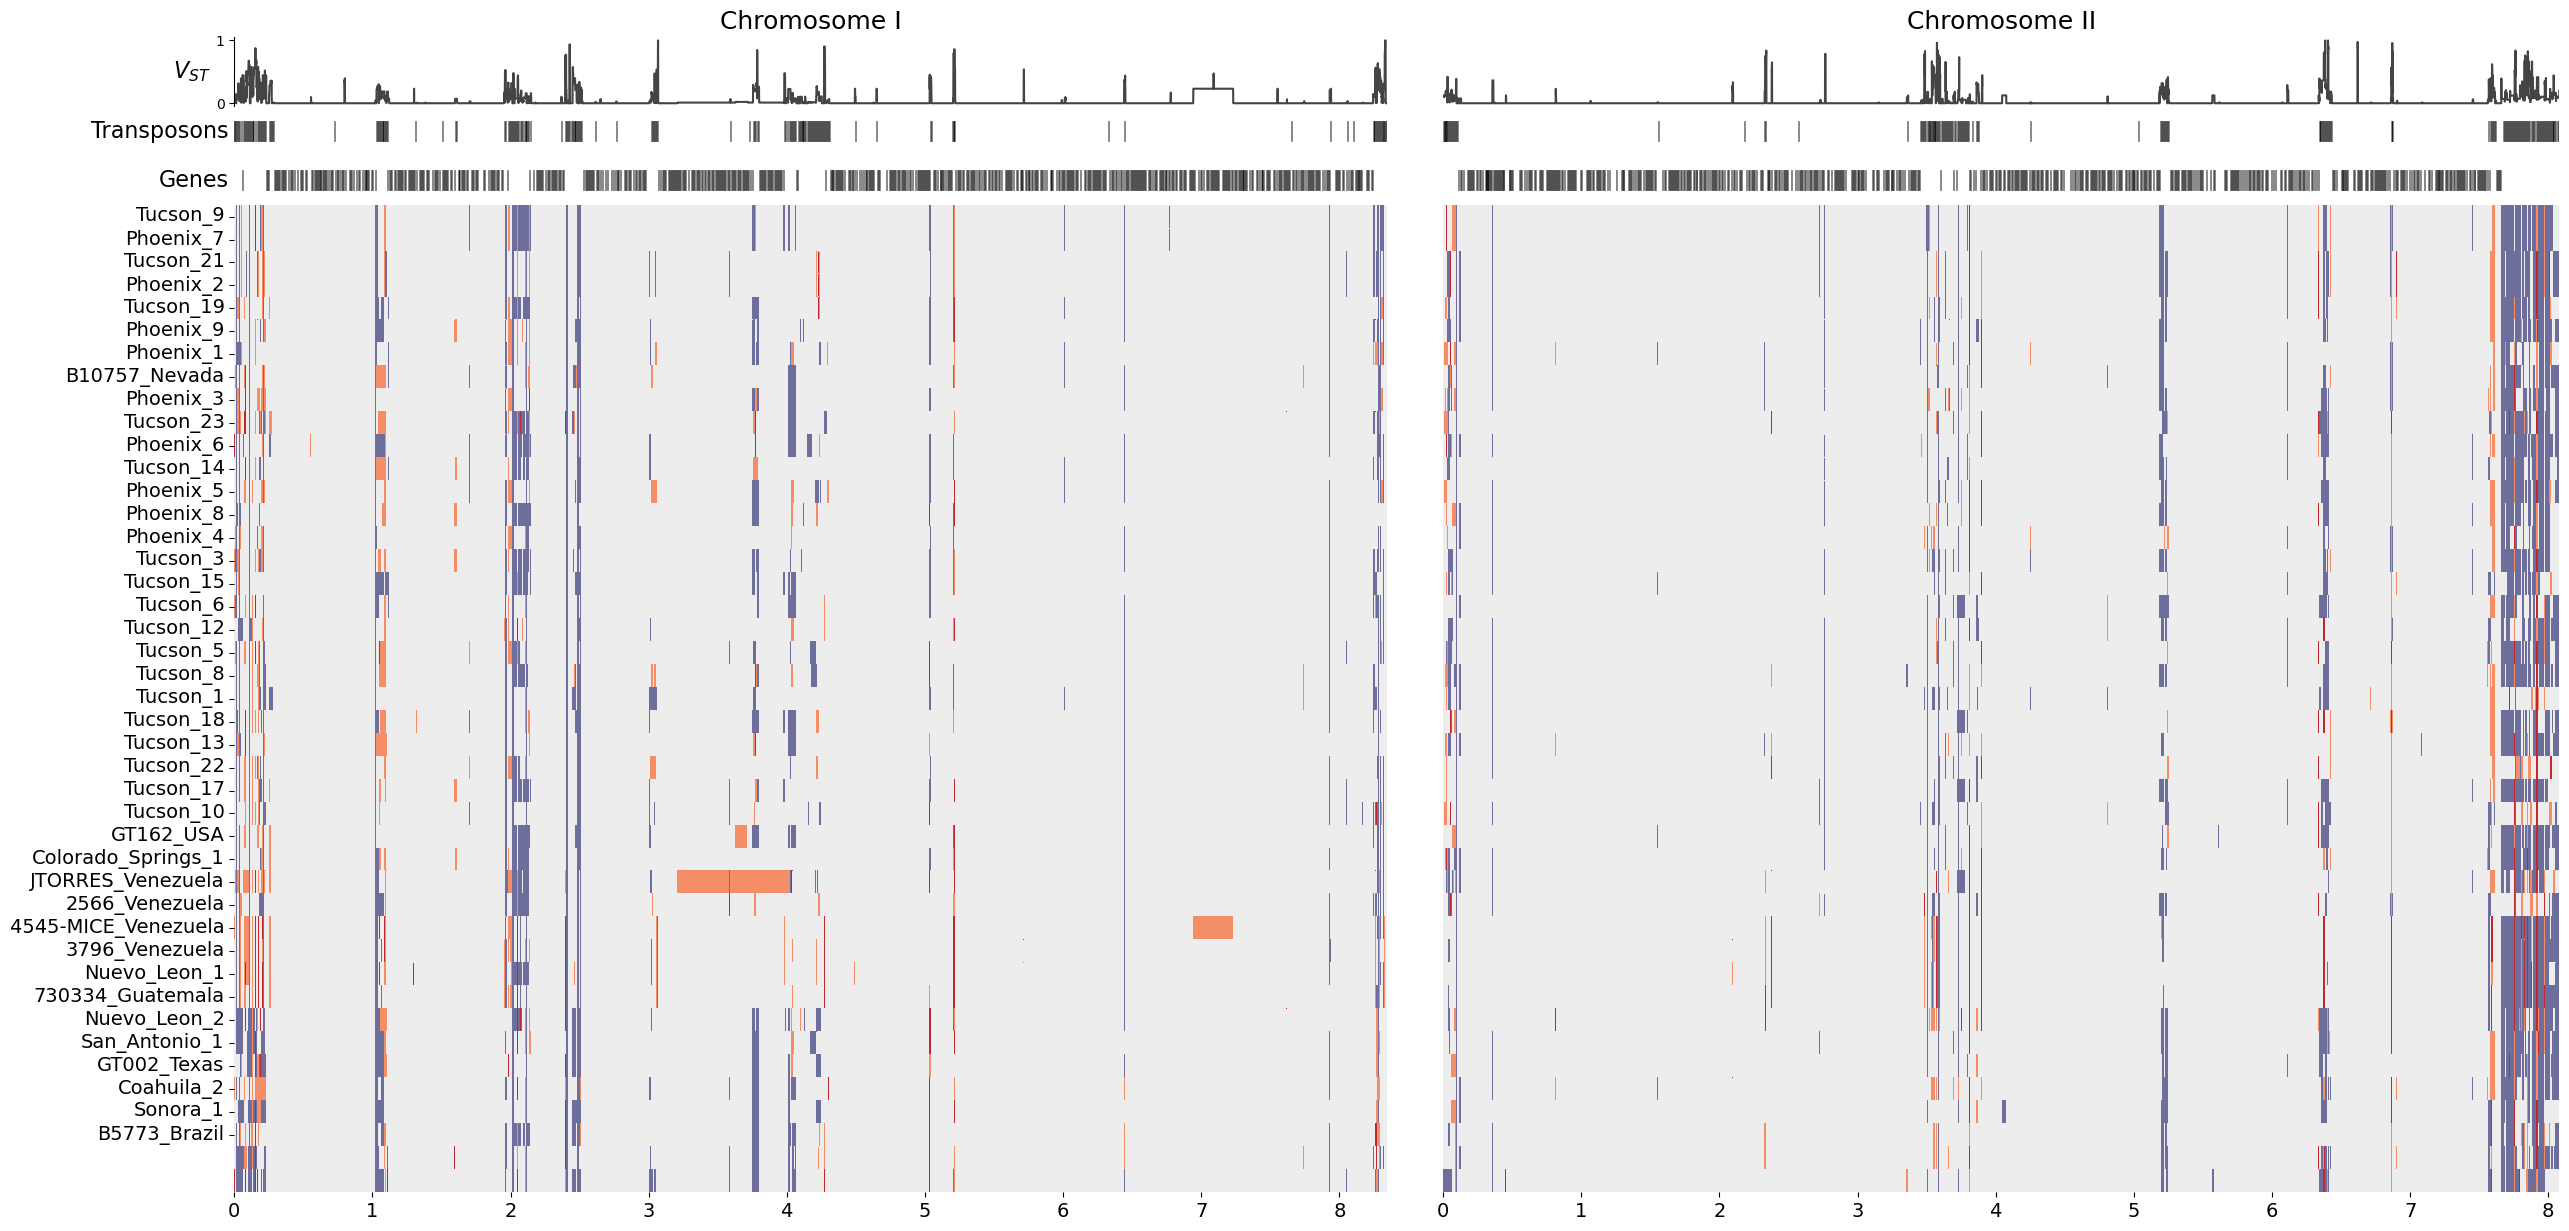

In [18]:
#first 2 chroms
fig, ax  = plt.subplots(4, 2, figsize=(30, 15), 
                        gridspec_kw={'width_ratios':[chr_lens_norm['CP075068.1'], chr_lens_norm['CP075069.1']],
                                     'height_ratios': [0.07,0.05,0.05,1]})
fig.subplots_adjust(hspace=0, wspace=0.05)

col = 0
for chrom_num, chrom in enumerate(sorted(df['Chromosome'].unique())[:2]):
    
    #VST plot    
    i = 0
    temp = df[df['Chromosome'] == chrom]
    ax[i,col].plot(temp['Start'], temp['VST_AZ_TXMXSA_CB'], line_cmap[0])
    
    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].spines['right'].set_visible(False)
    ax[i,col].spines['top'].set_visible(False)
    ax[i,col].spines['bottom'].set_visible(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_title('Chromosome {}'.format(num_to_roman[chrom_num+1]),fontsize = 18)

    if col == 0:
        ax[i,col].set_yticks([0,1])
        ax[i,col].set_ylabel('$V_{ST}$',rotation=0, va="center", ha="right", fontsize=16)
        
    else:
        ax[i,col].set_frame_on(False)
        ax[i,col].set_yticks([])

    #transposon locations 
    i+=1
    temp = transposons[transposons['chrom'] == chrom]
    for row in temp.iterrows():
        ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[1])

    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].set_frame_on(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_yticks([])
    if col == 0:
        ax[i,col].set_ylabel('Transposons',rotation=0, va="center", ha="right",  fontsize=16,)
    

    #gene locations
    i+=1
    temp = gff[gff['chrom'] == chrom]        
    for row in temp.iterrows():
        ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[2])
        
    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].set_frame_on(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_yticks([])
    if col == 0:
        ax[i,col].set_ylabel('Genes',rotation=0, va="center", ha="right",  fontsize=16,)

    #CNVs
    i+=1
    chr_df = df[df['Chromosome']==chrom].drop_duplicates('Start').set_index('Start')[sorted_strain_cols].transpose()
    chr_df.where(chr_df<3, 3, inplace=True)

    xticklabels = range(1,chr_lens[chrom], 1000000)
    xticks = [chr_df.columns.get_loc(x) for x in xticklabels]
    sns.heatmap(ax=ax[i, col], data=chr_df, cbar=False,
                cmap=cmap)
    
    ax[i,col].set_xticks(xticks)
    ax[i,col].set_xticklabels(range(len(xticklabels)), fontsize=14, rotation=0)
    ax[i,col].set_xlabel('')

    
    if col == 0:
        ax[i,col].set_yticks(np.arange(0,(len(sorted_strain_cols)))+.5)
        ax[i,col].set_yticklabels([s for s in sorted_strain_cols], fontsize=14, va="center")
    else:
        ax[i,col].set_yticks([])
        
    col += 1

plt.savefig('../figures/figS2_cnv_heatmap_top.png', facecolor='white', bbox_inches='tight', format='png', dpi=300)
plt.show()

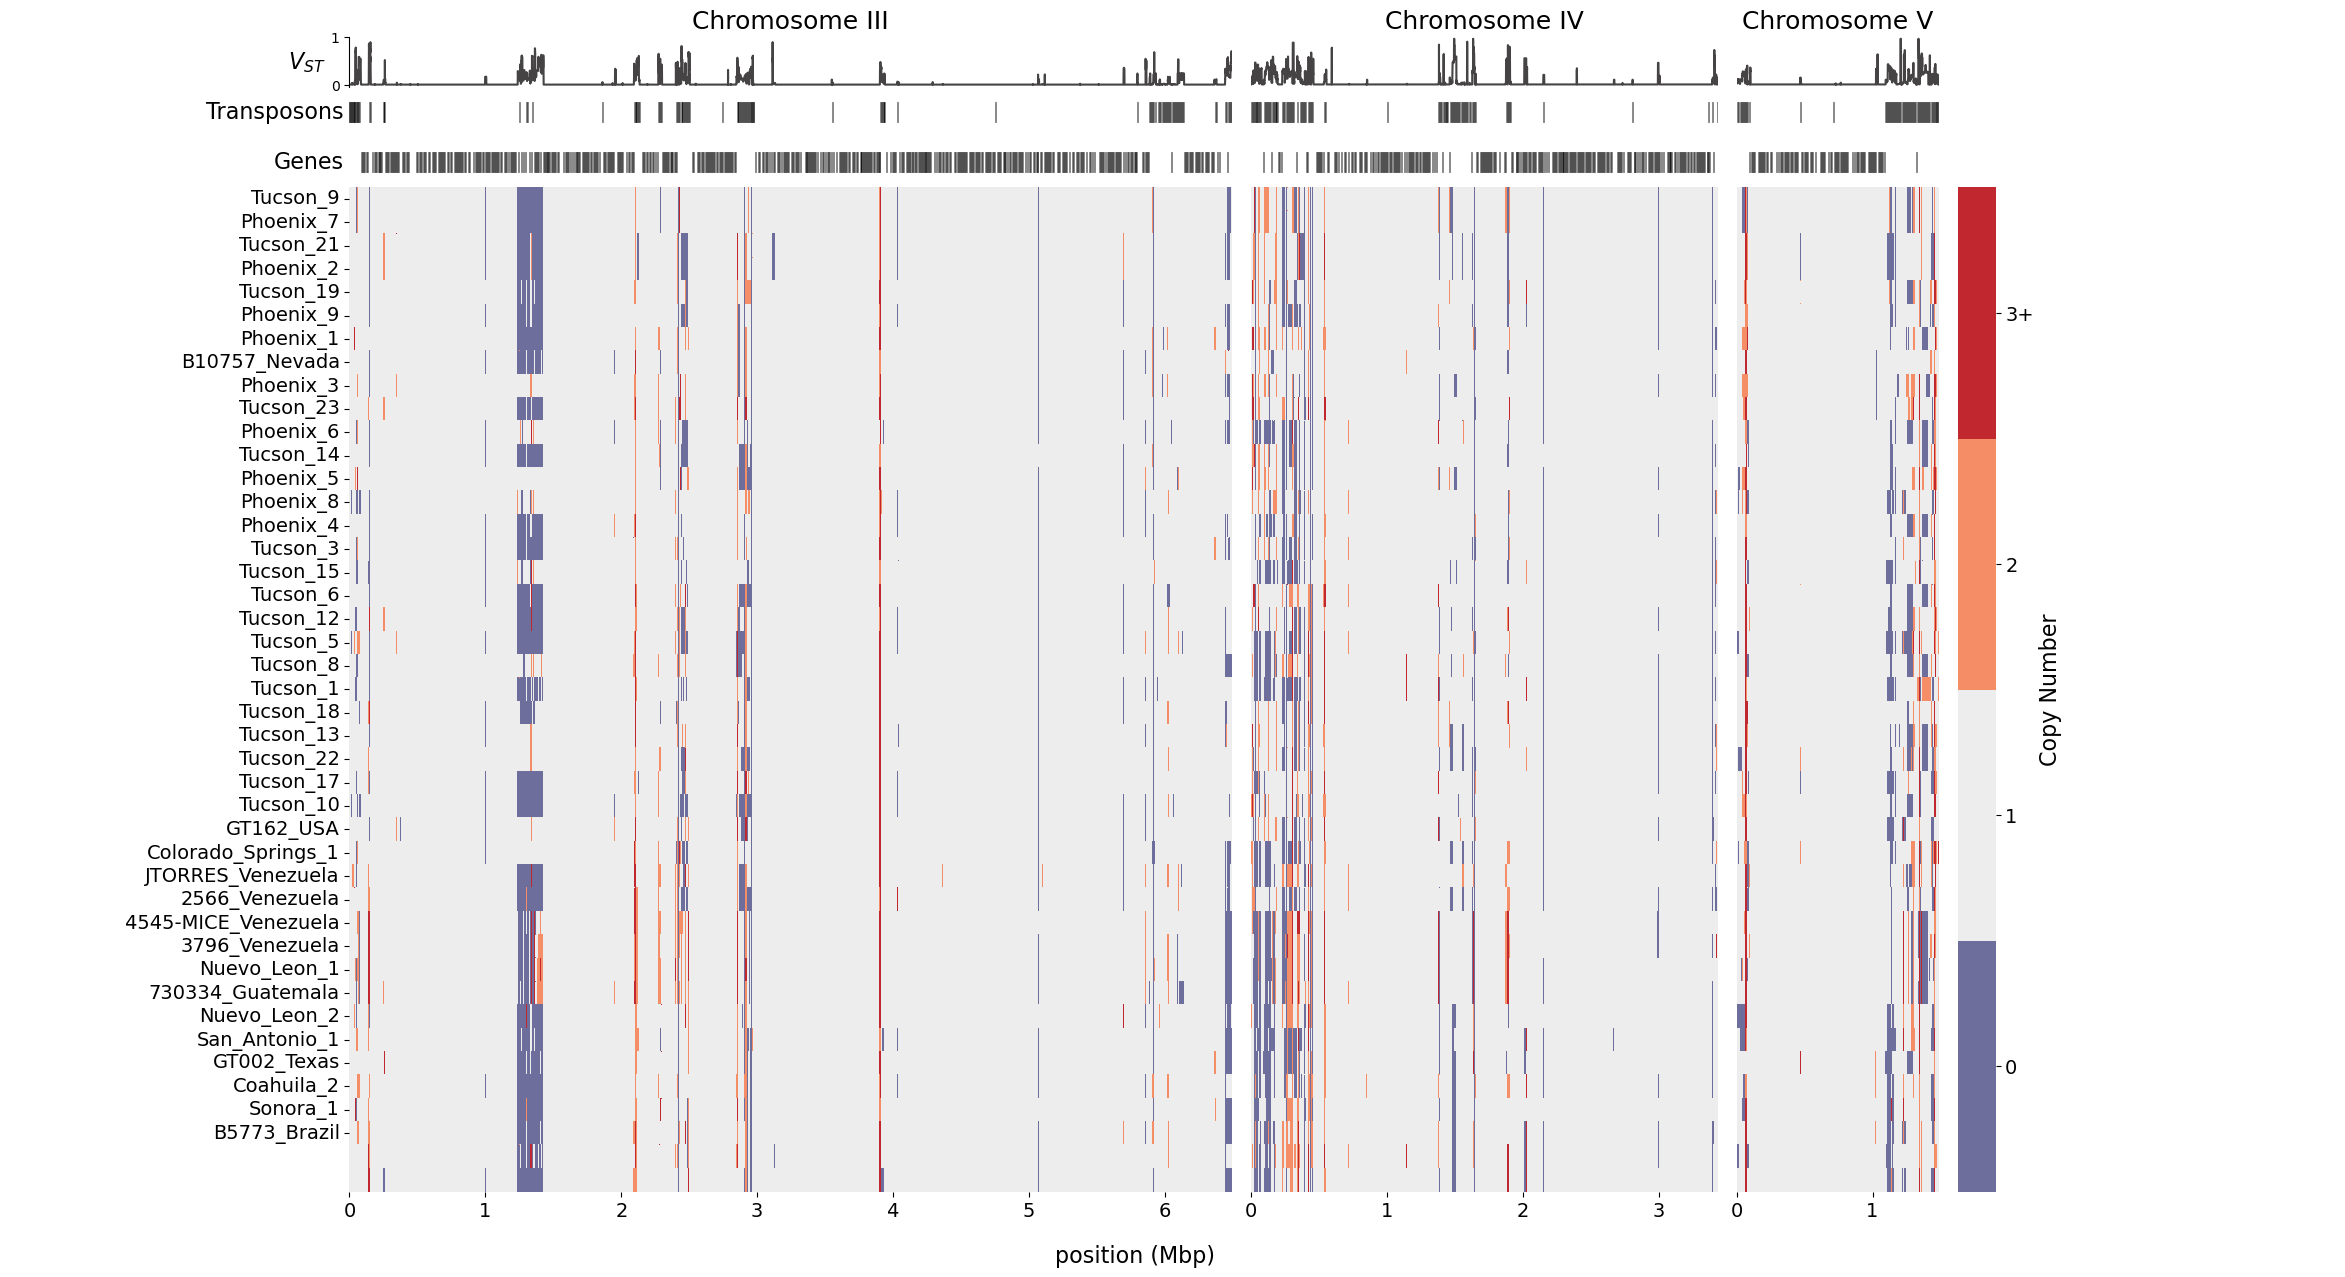

In [19]:
#last 3 chroms
cbar_width = 0.01
width_padding = (chr_lens_norm['CP075068.1'] + chr_lens_norm['CP075069.1'] - 
                (cbar_width + chr_lens_norm['CP075070.1'] + chr_lens_norm['CP075071.1'] + chr_lens_norm['CP075072.1'])) / 2

fig, ax  = plt.subplots(4, 6, figsize=(30, 15), 
                        gridspec_kw={'width_ratios':[width_padding, 
                                                     chr_lens_norm['CP075070.1'], chr_lens_norm['CP075071.1'], 
                                                     chr_lens_norm['CP075072.1'], cbar_width, width_padding],
                                     'height_ratios': [0.05,0.05,0.05,1]})
fig.subplots_adjust(hspace=0, wspace=0.05)

col = 1
for chrom_num, chrom in enumerate(sorted(df['Chromosome'].unique())[2:]):
    
    #VST plot    
    i = 0
    temp = df[df['Chromosome'] == chrom]
    ax[i,col].plot(temp['Start'], temp['VST_AZ_TXMXSA_CB'],color=line_cmap[0])
    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].spines['right'].set_visible(False)
    ax[i,col].spines['top'].set_visible(False)
    ax[i,col].spines['bottom'].set_visible(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_title('Chromosome {}'.format(num_to_roman[chrom_num+3]),fontsize = 18)

    if col == 1:
        ax[i,col].set_yticks([0,1])
        ax[i,col].set_ylabel('$V_{ST}$',rotation=0, va="center", ha="right", fontsize=16)
        
    else:
        ax[i,col].set_frame_on(False)
        ax[i,col].set_yticks([])

    #transposon locations 
    i+=1
    temp = transposons[transposons['chrom'] == chrom]
    for row in temp.iterrows():
        ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[1])
        
    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].set_frame_on(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_yticks([])
    if col == 1:
        ax[i,col].set_ylabel('Transposons',rotation=0, va="center", ha="right", fontsize=16)
    
    #gene locations
    i+=1
    temp = gff[gff['chrom'] == chrom]        
    for row in temp.iterrows():
        ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[2])

    ax[i,col].set_xlim(0,chr_lens[chrom])
    ax[i,col].set_frame_on(False)
    ax[i,col].set_xticks([])
    ax[i,col].set_yticks([])
    if col == 1:
        ax[i,col].set_ylabel('Genes',rotation=0, va="center", ha="right", fontsize=16)

    #CNVs
    i+=1
    chr_df = df[df['Chromosome']==chrom].drop_duplicates('Start').set_index('Start')[sorted_strain_cols].transpose()
    chr_df.where(chr_df<3, 3, inplace=True)

    xticklabels = range(1,chr_lens[chrom], 1000000)
    xticks = [chr_df.columns.get_loc(x) for x in xticklabels]
    
    #add colorbar
    if col == 3:
        sns.heatmap(ax=ax[i, col], data=chr_df, cbar_kws={'label':'Copy Number'}, 
                    cbar_ax=ax[i,col+1],cmap=cmap,)
        cbar = ax[i,col].collections[0].colorbar
        cbar.set_ticks([.375, 1.125, 1.875, 2.625])
        cbar.set_ticklabels(['0','1','2','3+'])
        cbar.ax.tick_params(labelsize=14)
        ax[i,col+1].yaxis.label.set_size(16)
        
    else:
        sns.heatmap(ax=ax[i, col], data=chr_df, cbar=False,cmap=cmap)
    
    ax[i,col].set_xticks(xticks)
    ax[i,col].set_xticklabels(range(len(xticklabels)), rotation=0, fontsize=14,)
    ax[i,col].set_xlabel('')

    
    #set strain labels
    if col == 1:
        ax[i,col].set_yticks(np.arange(0,(len(sorted_strain_cols)))+.5)
        ax[i,col].set_yticklabels([s for s in sorted_strain_cols], va="center", fontsize=14)
    else:
        ax[i,col].set_yticks([])
        
    col += 1

#hide first and last columns - these are just there for spacing
for row in range(4):
    ax[row,0].axis('off')
    ax[row,5].axis('off')

#hide rows above colorbar
for row in range(3):
    ax[row,4].axis('off')
    
fig.suptitle('position (Mbp)', fontsize=16, y=.075)
plt.savefig('../figures/figS2_cnv_heatmap_top.png', facecolor='white', bbox_inches='tight', format='png', dpi=300)
plt.show()

### Will combine these 2 figures into one using Adobe Illustrator.

### Chromosome 1 only:

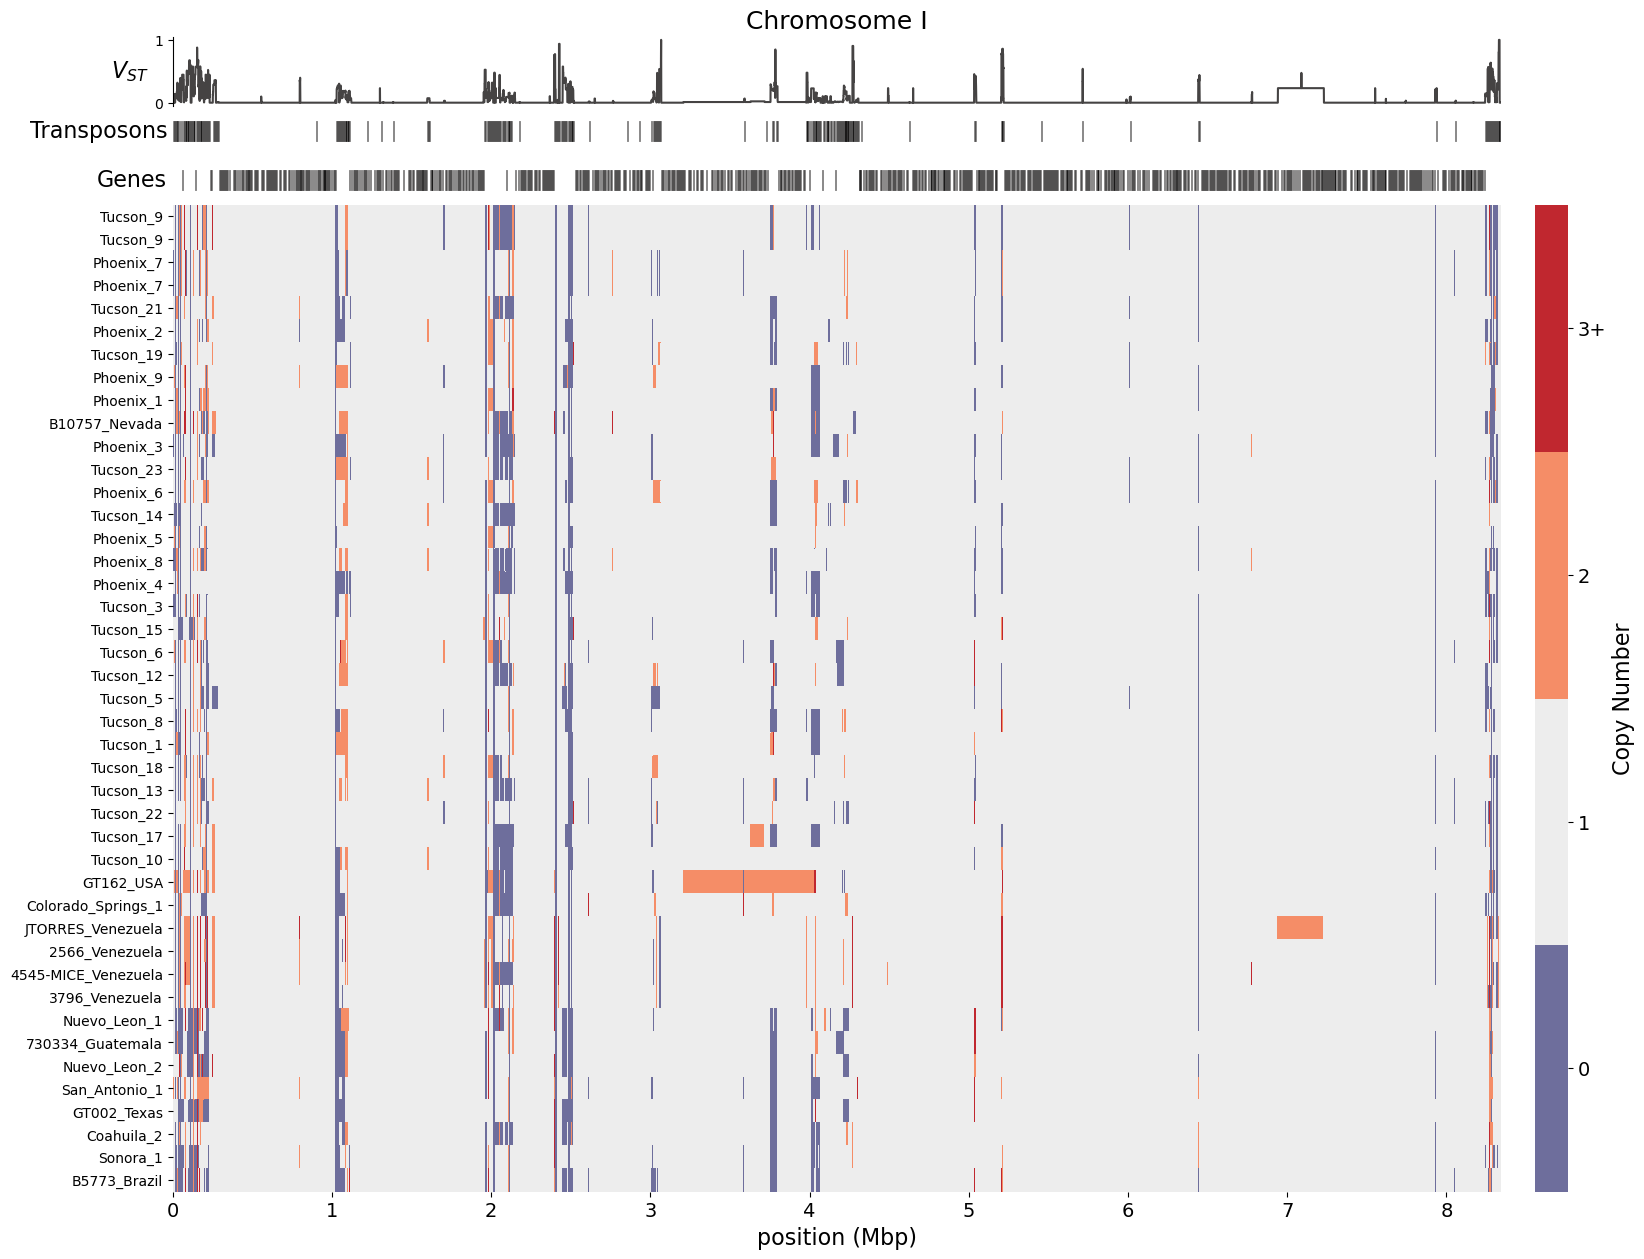

In [20]:
#first 2 chroms
fig, ax  = plt.subplots(4, 2, figsize=(18, 15), 
                        gridspec_kw={'width_ratios':[1,0.025],
                                     'height_ratios': [0.07,0.05,0.05,1]})
fig.subplots_adjust(hspace=0, wspace=0.05)

col = 0
chrom_num = 0
chrom = 'CP075068.1'
    
#VST plot    
i = 0
temp = df[df['Chromosome'] == chrom]
ax[i,col].plot(temp['Start'], temp['VST_AZ_TXMXSA_CB'], line_cmap[0])

ax[i,col].set_xlim(0,chr_lens[chrom])
ax[i,col].spines['right'].set_visible(False)
ax[i,col].spines['top'].set_visible(False)
ax[i,col].spines['bottom'].set_visible(False)
ax[i,col].set_xticks([])
ax[i,col].set_title('Chromosome {}'.format(num_to_roman[chrom_num+1]),fontsize = 18)

if col == 0:
    ax[i,col].set_yticks([0,1])
    ax[i,col].set_ylabel('$V_{ST}$',rotation=0, va="center", ha="right", fontsize=16)

else:
    ax[i,col].set_frame_on(False)
    ax[i,col].set_yticks([])

#transposon locations 
i+=1
temp = transposons[transposons['chrom'] == chrom]
for row in temp.iterrows():
    ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[1])

ax[i,col].set_xlim(0,chr_lens[chrom])
ax[i,col].set_frame_on(False)
ax[i,col].set_xticks([])
ax[i,col].set_yticks([])
if col == 0:
    ax[i,col].set_ylabel('Transposons',rotation=0, va="center", ha="right",  fontsize=16,)


#gene locations
i+=1
temp = gff[gff['chrom'] == chrom]        
for row in temp.iterrows():
    ax[i,col].hlines(0, int(row[1]['start']), int(row[1]['stop']), linewidth=15, color=line_cmap[2])

ax[i,col].set_xlim(0,chr_lens[chrom])
ax[i,col].set_frame_on(False)
ax[i,col].set_xticks([])
ax[i,col].set_yticks([])
if col == 0:
    ax[i,col].set_ylabel('Genes',rotation=0, va="center", ha="right",  fontsize=16,)

#CNVs
i+=1
chr_df = df[df['Chromosome']==chrom].drop_duplicates('Start').set_index('Start')[sorted_strain_cols].transpose()
chr_df.where(chr_df<3, 3, inplace=True)

xticklabels = range(1,chr_lens[chrom], 1000000)
xticks = [chr_df.columns.get_loc(x) for x in xticklabels]

sns.heatmap(ax=ax[i, col], data=chr_df, cbar_kws={'label':'Copy Number'}, 
                    cbar_ax=ax[i,col+1],cmap=cmap,)
cbar = ax[i,col].collections[0].colorbar
cbar.set_ticks([.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(['0','1','2','3+'])
cbar.ax.tick_params(labelsize=14)
ax[i,col+1].yaxis.label.set_size(16)

ax[i,col].set_xticks(xticks)
ax[i,col].set_xticklabels(range(len(xticklabels)), fontsize=14, rotation=0)
ax[i,col].set_xlabel('position (Mbp)', fontsize=16)

#hide rows above colorbar
for row in range(3):
    ax[row,1].axis('off')
    
plt.savefig('../figures/fig3A_chr1_CNV.png', dpi=300, facecolor='white', bbox_inches='tight', format='png')

plt.show()